# Лабораторная работа 6


## Цель

Прогноз успеха фильмов по обзорам (Predict Sentiment From Movie Reviews)

## Задачи

- Ознакомиться с задачей классификации
- Изучить способы представления текста для передачи в ИНС
- Достигнуть точность прогноза не менее 95%

## Выполнение работы


Начнем с импорта зависимостей


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

2024-12-11 05:50:53.006012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Загружаем датасет и сразу объединяем его для последующего разделения на 20/80


In [2]:
from keras.datasets import imdb

(training_data, training_targets), (testing_data,
                                    testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets),
                         axis=0)

In [3]:
print("Categories:", np.unique(targets))
print("Number of unique words:",
      len(np.unique(np.hstack(data))))

length = [len(i) for i in data]
print("Average Review length:", np.mean(length))
print("Standard Deviation:", round(np.std(length)))

Categories: [0 1]
Number of unique words: 9998
Average Review length: 234.75892
Standard Deviation: 173


Можно видеть, что все данные относятся к двум категориям: 0 или 1, что представляет
собой настроение обзора. Весь датасет содержит 9998 уникальных слов, средний размер
обзора составляет 234 слова со стандартным отклонением 173


Рассмотрим первый положительный отзыв


In [4]:
print("Label:", targets[0])
Label: 1
print(data[0])

Label: 1
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Мы видим отзыв в виде индексов, а теперь преобразуем их в слова, каждое неизвестное слово заменяется на #


In [5]:
index = imdb.get_word_index()
reverse_index = dict([(value,  key) for (key,  value) in
                      index.items()])
decoded = " ".join([reverse_index.get(i - 3, "#") for i in
                    data[0]])
print(decoded)

# this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert # is an amazing actor and now the same being director # father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for # and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also # to the two little boy's that played the # of norman and paul they were just brilliant children are often left out of the # list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

Векторизируем данные. Каждый обзор представляет собой вектор индексов, так как нейросеть требует от нас одинакового размера входных данных, то мы преобразуем все обзоры в так называемый мешок слов. Сделаем массив, где каждая строка это наш обзор, а столбцов = 10000(потому что всего униклаьных слов примерно такое кол-во) и все заполняем нулями. Если индекс какого то слова встречается в обзоре, то мы меняем значение столбца в строке обзора на 1, например:
У нас есть обзор

```python
sequence = [1, 3, 6] #это вектор из индексов слов
```

Следовательно после векторизации, где у нас будет соотвествующая строчка обозначать номер обзора, она примет значение

```python
arr = [0, 1, 0, 1, 0, 0, 1, 0, 0 ...]
          |     |        |
       0, 1, 2, 3, 4, 5, 6, 7, 8, 9
```


In [6]:
def vectorize(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results


data = vectorize(data)
targets = np.array(targets).astype("float32")

Разделим датасет на обучающий и тестировочный наборы. Обучающий набор будет
состоять из 40 000 обзоров, тестировочный — из 10 000.


In [7]:
test_x = data[:10000]
test_y = targets[:10000]
train_x = data[10000:]
train_y = targets[10000:]

Созддаем модель


In [8]:
# orig_model = models.Sequential()
# # Input - Layer
# orig_model.add(layers.Dense(50, activation="relu",
#                             input_shape=(10000, )))
# # Hidden - Layers
# orig_model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
# orig_model.add(layers.Dense(50, activation="relu"))
# orig_model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
# orig_model.add(layers.Dense(50, activation="relu"))
# # Output- Layer
# orig_model.add(layers.Dense(1, activation="sigmoid"))
# orig_model.summary()

In [9]:
# orig_model.compile(
#     optimizer="adam",
#     loss="binary_crossentropy",
#     metrics=["accuracy"]
# )
# original_history = orig_model.fit(
#     train_x, train_y,
#     epochs=2,
#     batch_size=500,
#     validation_data=(test_x, test_y)
# )

ЕСЛИ ЭТО ЗАПУСТИТЬ, ТО ПРОИЗОЙДЕТ РАЗРЫВ)))


<function matplotlib.pyplot.show(close=None, block=None)>

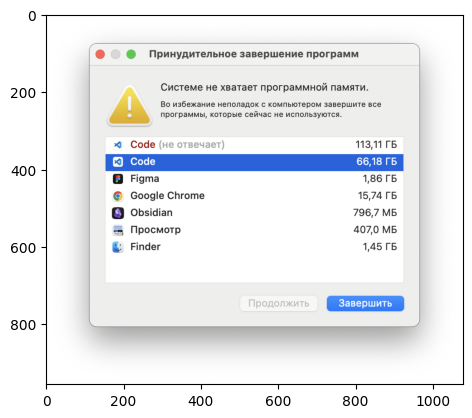

In [ ]:
plt.imshow(plt.imread("../Датасеты/Снимок экрана 2024-12-11 в 05.43.46.png"))
plt.show

Собираем свою модель


In [10]:
# Input - Layer
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

2024-12-11 05:51:04.674126: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-11 05:51:04.674329: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-11 05:51:04.674354: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-11 05:51:04.674469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 05:51:04.674533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 642,177
Trainable params: 642,177
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True)

modern_results = model.fit(
    train_x, train_y,
    epochs=8,
    batch_size=128,
    validation_data=(test_x, test_y),
    callbacks=[early_stopping]
)

Epoch 1/8


2024-12-11 05:51:10.190864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 05:51:10.297957: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


313/313 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8236

2024-12-11 05:51:17.909737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 10s 24ms/step - loss: 0.3949 - accuracy: 0.8236 - val_loss: 0.2705 - val_accuracy: 0.8941
Epoch 2/8
313/313 [==============================] - 6s 19ms/step - loss: 0.2603 - accuracy: 0.8995 - val_loss: 0.2720 - val_accuracy: 0.8956
Epoch 3/8
313/313 [==============================] - 6s 19ms/step - loss: 0.2307 - accuracy: 0.9140 - val_loss: 0.2773 - val_accuracy: 0.8969
Epoch 4/8
313/313 [==============================] - 6s 19ms/step - loss: 0.2131 - accuracy: 0.9214 - val_loss: 0.2954 - val_accuracy: 0.8897


In [ ]:
def plot_model_comparison(histories, model_names=None):
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(histories))]

    for i, history in enumerate(histories):
        plt.plot(history.history['loss'],
                 label=f'{model_names[i]} - Training Loss')
        plt.plot(history.history['val_loss'],
                 label=f'{model_names[i]} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Comparison of Training and Validation Loss')
    plt.legend()
    plt.show()

    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'],
                 label=f'{model_names[i]} - Training Accuracy')
        plt.plot(history.history['val_accuracy'],
                 label=f'{model_names[i]} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Training and Validation Accuracy')
    plt.legend()
    plt.show()

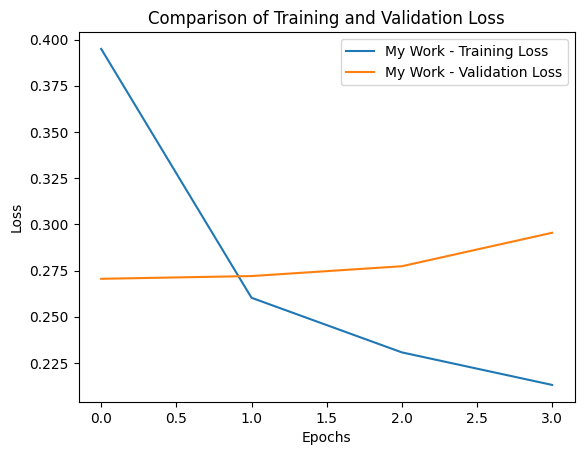

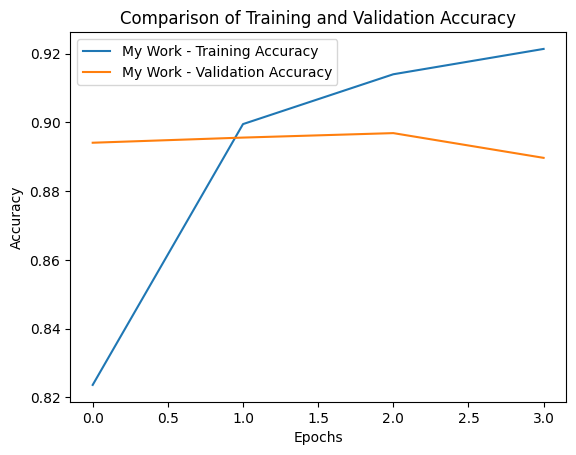

In [17]:
plot_model_comparison(histories=[modern_results], model_names=["My Work"])

In [19]:
results = model.evaluate(test_x, test_y)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")

313/313 [==============================] - 3s 9ms/step - loss: 0.2705 - accuracy: 0.8941
Test Loss: 0.2705, Test Accuracy: 0.8941


## Дополнительные задания


### Написать функцию, которая позволяет ввести пользовательский текст


In [21]:
# Преобразуем отзыв в последовательность индексов
def review_to_sequence(review, word_index):
    words = review.lower().split()
    sequence = [word_index.get(word, 0)
                for word in words if word_index.get(word, 0) < 10000]
    return sequence

# Векторизация отзыва


def vectorize_review(sequence, dimension=10000):
    vector = np.zeros((1, dimension))  # Один отзыв, поэтому (1, dimension)
    vector[0, sequence] = 1
    return vector


def solution(review):
    review_sequence = review_to_sequence(review, index)
    review_vector = vectorize_review(review_sequence)

    prediction = model.predict(review_vector, verbose=0)

    if prediction > 0.5:
        print("Скорее всего отзыв положительный, вероятность этого =",
              prediction[0][0])
    else:
        print("Скорее всего отзыв отрицательный, вероятность этого =",
              1 - prediction[0][0])


# solution(input("Напишите отзыв"))

solution("Horrible disgusting movie, complete crap, I will never watch it again")
solution("Very cool movie, great acting, great script and a thrilling adventure.")

Скорее всего отзыв отрицательный, вероятность этого = 0.6662020087242126
Скорее всего отзыв положительный, вероятность этого = 0.52948374


## Исследовать результаты при различном размере вектора представления текста



Training with vector size: 500
Epoch 1/8


2024-12-11 06:22:28.189678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 06:22:28.273064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


247/250 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.6548

2024-12-11 06:22:32.377669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 5s 17ms/step - loss: 0.6828 - accuracy: 0.6557 - val_loss: 0.4043 - val_accuracy: 0.8198
Epoch 2/8
250/250 [==============================] - 4s 15ms/step - loss: 0.4672 - accuracy: 0.7868 - val_loss: 0.3754 - val_accuracy: 0.8372
Epoch 3/8
250/250 [==============================] - 4s 15ms/step - loss: 0.4319 - accuracy: 0.8090 - val_loss: 0.3719 - val_accuracy: 0.8393
Epoch 4/8
250/250 [==============================] - 4s 15ms/step - loss: 0.4174 - accuracy: 0.8160 - val_loss: 0.3747 - val_accuracy: 0.8364
Epoch 5/8
250/250 [==============================] - 4s 15ms/step - loss: 0.4088 - accuracy: 0.8232 - val_loss: 0.3688 - val_accuracy: 0.8419
Epoch 6/8
250/250 [==============================] - 4s 15ms/step - loss: 0.4032 - accuracy: 0.8250 - val_loss: 0.3685 - val_accuracy: 0.8446
Epoch 7/8
250/250 [==============================] - 4s 15ms/step - loss: 0.4002 - accuracy: 0.8265 - val_loss: 0.3683 - val_accuracy: 0.8443
Epoch 8/8
313/31

2024-12-11 06:23:03.114879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 06:23:03.197936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


249/250 [============================>.] - ETA: 0s - loss: 0.5284 - accuracy: 0.7377

2024-12-11 06:23:07.140220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 5s 17ms/step - loss: 0.5276 - accuracy: 0.7382 - val_loss: 0.2910 - val_accuracy: 0.8826
Epoch 2/8
250/250 [==============================] - 4s 15ms/step - loss: 0.3434 - accuracy: 0.8600 - val_loss: 0.2812 - val_accuracy: 0.8855
Epoch 3/8
250/250 [==============================] - 4s 15ms/step - loss: 0.3155 - accuracy: 0.8717 - val_loss: 0.2788 - val_accuracy: 0.8889
Epoch 4/8
250/250 [==============================] - 4s 15ms/step - loss: 0.3044 - accuracy: 0.8781 - val_loss: 0.2787 - val_accuracy: 0.8886
Epoch 5/8
250/250 [==============================] - 4s 15ms/step - loss: 0.2965 - accuracy: 0.8826 - val_loss: 0.2770 - val_accuracy: 0.8895
Epoch 6/8
250/250 [==============================] - 4s 15ms/step - loss: 0.2910 - accuracy: 0.8840 - val_loss: 0.2771 - val_accuracy: 0.8865
Epoch 7/8
250/250 [==============================] - 4s 16ms/step - loss: 0.2892 - accuracy: 0.8855 - val_loss: 0.2771 - val_accuracy: 0.8885
Epoch 8/8
313/31

2024-12-11 06:23:39.384252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 06:23:39.469784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


249/250 [============================>.] - ETA: 0s - loss: 0.4443 - accuracy: 0.7887

2024-12-11 06:23:44.008873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 6s 19ms/step - loss: 0.4439 - accuracy: 0.7890 - val_loss: 0.2651 - val_accuracy: 0.8947
Epoch 2/8
250/250 [==============================] - 4s 15ms/step - loss: 0.2796 - accuracy: 0.8903 - val_loss: 0.2559 - val_accuracy: 0.8979
Epoch 3/8
250/250 [==============================] - 4s 15ms/step - loss: 0.2513 - accuracy: 0.9010 - val_loss: 0.2581 - val_accuracy: 0.8986
Epoch 4/8
250/250 [==============================] - 4s 15ms/step - loss: 0.2402 - accuracy: 0.9091 - val_loss: 0.2607 - val_accuracy: 0.8988
Epoch 5/8
313/313 [==============================] - 3s 9ms/step - loss: 0.2752 - accuracy: 0.8902
Test Loss: 0.2752, Test Accuracy: 0.8902

Training with vector size: 7000
Epoch 1/8


2024-12-11 06:24:06.483260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 06:24:06.567420: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


249/250 [============================>.] - ETA: 0s - loss: 0.4214 - accuracy: 0.8014

2024-12-11 06:24:11.454525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 6s 21ms/step - loss: 0.4210 - accuracy: 0.8017 - val_loss: 0.2632 - val_accuracy: 0.8945
Epoch 2/8
250/250 [==============================] - 4s 17ms/step - loss: 0.2726 - accuracy: 0.8932 - val_loss: 0.2532 - val_accuracy: 0.8992
Epoch 3/8
250/250 [==============================] - 4s 17ms/step - loss: 0.2381 - accuracy: 0.9088 - val_loss: 0.2813 - val_accuracy: 0.8878
Epoch 4/8
250/250 [==============================] - 4s 17ms/step - loss: 0.2245 - accuracy: 0.9149 - val_loss: 0.2607 - val_accuracy: 0.8997
Epoch 5/8
313/313 [==============================] - 3s 9ms/step - loss: 0.2698 - accuracy: 0.8923
Test Loss: 0.2698, Test Accuracy: 0.8923


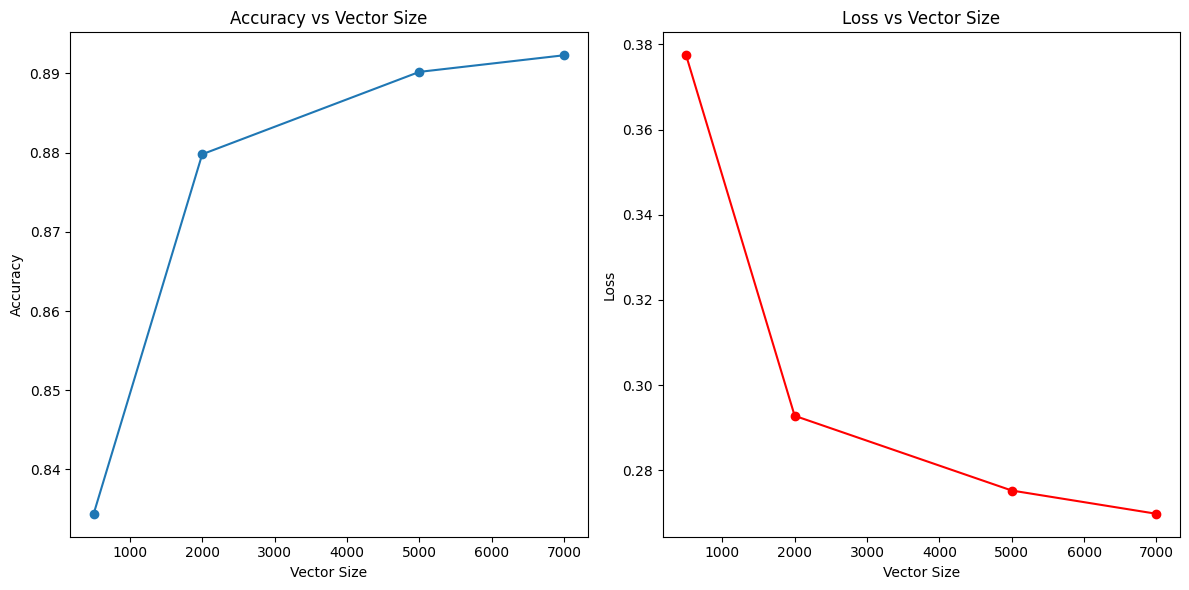

In [28]:
# Функция для экспериментов с размером вектора
def experiment_with_vector_size(vector_sizes):
    results = {}
    for size in vector_sizes:
        print(f"\nTraining with vector size: {size}")

        # Построение модели
        model = models.Sequential()
        model.add(layers.Dense(64, activation="relu", input_shape=(size,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(1, activation="sigmoid"))

        # Компиляция модели
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=3, restore_best_weights=True)
        # Уменьшение данных до текущего размера вектора
        train_x_resized = train_x[:, :size]
        test_x_resized = test_x[:, :size]

        # Обучение модели
        history = model.fit(train_x_resized, train_y, epochs=8,
                            batch_size=128, validation_split=0.2, verbose=1, callbacks=early_stopping)

        # Оценка модели
        test_loss, test_acc = model.evaluate(test_x_resized, test_y, verbose=1)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        # Сохранение результатов
        results[size] = {'loss': test_loss, 'accuracy': test_acc}

    return results


# Исследование различных размеров вектора
vector_sizes = [500, 2000, 5000, 7000]
results = experiment_with_vector_size(vector_sizes)

# Визуализация результатов
sizes = list(results.keys())
accuracies = [results[size]['accuracy'] for size in sizes]
losses = [results[size]['loss'] for size in sizes]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sizes, accuracies, marker='o')
plt.title("Accuracy vs Vector Size")
plt.xlabel("Vector Size")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(sizes, losses, marker='o', color='red')
plt.title("Loss vs Vector Size")
plt.xlabel("Vector Size")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()